<a href="https://colab.research.google.com/github/tommyj530/Learning-based-comms-system-using-autoencoder-and-CGAN/blob/main/CGAN_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGANAutoencoder-Based End-to-End Communications System
ELEC825 Machine Learning and Deep Learning @ Queen's University Kingston, ON

Author: Thomas Jung

Date: March 27, 2021

## CGAN for channel estimation
Train a GAN to mimik any unknown channel function.
Reference: https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/ 

### Setup

#### Import libraries

In [ ]:
import glob
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Ignore if you do not have multiple GPUs

import time 
from IPython import display

In [ ]:
print(tf.__version__)

2.4.1


#### System parameters

In [ ]:
k = 4       # Number of information bits per message, i.e., M=2**k
n = 2      # Number of real channel uses per message

In [ ]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

In [ ]:
train_SNR_dB = 15 
batch_size = 16
noise_std = EbNo2Sigma(train_SNR_dB) # should be able to vary this based on SNR

#number of neurons per layer in discriminator and generator
G_nb_weights = 46 #46 with 3 layers will give 4648 trainable params for the genorator, the VAE has 4614
D_nb_weights = 32 

### Define Generator and Discriminator

#### Generator

In [ ]:
# Concatenate z and y
G_input = tf.keras.Input(shape=(n,), dtype=tf.float32, name='gen_in') 
G_n = tf.random.normal([tf.shape(G_input)[0],n],dtype=tf.float32)
input = tf.concat(values=[G_input, G_n], axis=1)
x = tf.keras.layers.Dense(G_nb_weights,activation="relu")(input)
#x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(G_nb_weights,activation="relu")(x)
x = tf.keras.layers.Dense(G_nb_weights,activation="relu")(x)
x = tf.keras.layers.Dense(n,activation=None)(x)
G_output = x
generator = tf.keras.Model(G_input, G_output, name='generator')
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_in (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           gen_in[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
__________________________________________________________________________________________________
tf.random.normal (TFOpLambda)   (None, 2)            0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________

#### Discriminator
*  D(y,x)
*   y_fake = generator(x)
*   y_real = real_channel(x)

In our experiment, we use a stochastic channel model to generate y_real, but in practice, we would be taking measurements of the distorted signals and use them as a conditioning paramter for the GAN.

In [ ]:
# Concatenate x and y
D_input_y = tf.keras.Input(shape=(n,), dtype=tf.float32, name='D_in_y')
D_input_x = tf.keras.Input(shape=(n,), dtype=tf.float32, name='D_in_x')
input = tf.concat(values=[D_input_y, D_input_x], axis=1)
x = tf.keras.layers.Dense(D_nb_weights,activation="relu")(input)
#x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(D_nb_weights,activation=None)(x)
x = tf.keras.layers.Dense(1,activation=None)(x)
x = tf.keras.activations.sigmoid(x)
D_output = x
discriminator = tf.keras.Model([D_input_y, D_input_x], D_output, name='discriminator')
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in_y (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
D_in_x (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.concat_1 (TFOpLambda)        (None, 4)            0           D_in_y[0][0]                     
                                                                 D_in_x[0][0]                     
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           160         tf.concat_1[0][0]    

#### Test Generator and Discriminator

In [ ]:
x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
#x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
generated_signal = generator(x, training=False)
decision = discriminator([generated_signal,x])
#print(decision)

### Defin training Parameters

#### Define real channel

Rayleigh distribution
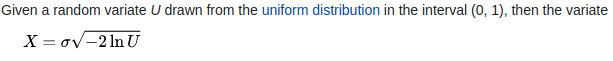


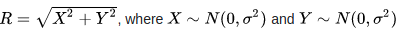

Rician distribution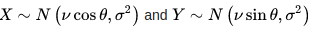

In [ ]:
# # Use a relatively high variance to see the difference between AWGN and Rayleigh
# noise_std = 2

In [ ]:
def real_channel(x):
    # Black-box Channel
    #AWGN
    #return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)
    return x + tf.random.normal(shape=tf.shape(x)) * tf.cast(noise_std,dtype=tf.float32)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random.uniform(tf.shape(x), minval=-3, maxval=3)

##### Visualize channel pdf

In [ ]:
def visualize_cpdf():
  #parameters
  hist_range = 3
  for i in range(5000):
    hist_range = 3
    rv_simple = tf.random.normal([batch_size, n])
    if i == 0:
      y_real = np.array(real_channel(rv_simple))
      y_real = y_real.squeeze().tolist()
    else:
      temp = np.array(real_channel(rv_simple))
      temp = temp.squeeze().tolist()
      y_real = np.append(y_real,temp)

  #and plot results  
  plt.hist(y_real,bins=100,range=(-hist_range,hist_range),density=True,histtype='step') 
  plt.title("channel distribution")
  plt.legend(["target"])
  plt.show()

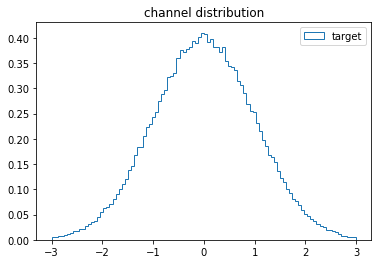

In [ ]:
visualize_cpdf()

#### Define loss for G and D

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
    # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # total_loss = real_loss + fake_loss
    return total_loss

#     D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))   #use "-" sign to minimize rather than maximize loss
#     G_loss = -tf.reduce_mean(tf.log(D_fake))

In [ ]:
def generator_loss(fake_output):
    return  -tf.reduce_mean(tf.math.log(fake_output))

#### Define optimizer for G and D

RMS prop works the best. Adam optimizer does not work for unknown reasons.


In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

### Training

In [ ]:
EPOCHS = 20
noise_dim = n 

#### Train function
Alternates between training the generator and discriminator while keeping the adversary's weights constant.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step():
  rv_simple = tf.random.normal([batch_size, noise_dim])
  #rv_simple = x/tf.sqrt(2*tf.reduce_mean(tf.square(rv_simple)))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    y_fake = generator(rv_simple, training=True)
    y_real = real_channel(rv_simple)

    real_output = discriminator([y_real,rv_simple], training=True)
    fake_output = discriminator([y_fake,rv_simple], training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

#### Test function
Tests the generator by plotting a histogram of its probability distribution and comparing it to that of the real channel

In [ ]:
#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.math.log(p / q))

In [ ]:
def test_step():
  #parameters
  hist_range = 3
  for i in range(1000):
    hist_range = 3
    rv_simple = tf.random.normal([batch_size, noise_dim])
    if i == 0:
      y_fake = np.array(generator(rv_simple))
      y_fake = y_fake.squeeze().tolist()
      y_real = np.array(real_channel(rv_simple))
      y_real = y_real.squeeze().tolist()
    else:
      temp = np.array(generator(rv_simple))
      temp = temp.squeeze().tolist()
      y_fake = np.append(y_fake,temp)
      temp = np.array(real_channel(rv_simple))
      temp = temp.squeeze().tolist()
      y_real = np.append(y_real,temp)

  #and plot results  
  plt.hist(y_fake,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')   
  plt.hist(y_real,bins=100,range=(-hist_range,hist_range),density=True,histtype='step') 
  plt.title("channel distribution")
  plt.legend(["generator", "target"])
  plt.show()

In [ ]:
def KL():
  #parameters
  hist_range = 3
  for i in range(1000):
    hist_range = 3
    rv_simple = tf.random.normal([batch_size, noise_dim])
    if i == 0:
      y_fake = np.array(generator(rv_simple))
      y_fake = y_fake.squeeze().tolist()
      y_real = np.array(real_channel(rv_simple))
      y_real = y_real.squeeze().tolist()
    else:
      temp = np.array(generator(rv_simple))
      temp = temp.squeeze().tolist()
      y_fake = np.append(y_fake,temp)
      temp = np.array(real_channel(rv_simple))
      temp = temp.squeeze().tolist()
      y_real = np.append(y_real,temp)

  # #fake noise 
  # y_p=tf.reshape(y_fake-rv_simple,(-1,))
  # #real noise
  # y_q=tf.reshape(y_real-rv_simple,(-1,))

  #histograms of noise vectors
  p = tf.histogram_fixed_width(y_real,value_range=tf.constant([-hist_range, hist_range], dtype=tf.float32),nbins=100)
  q = tf.histogram_fixed_width(y_fake,value_range=tf.constant([-hist_range, hist_range], dtype=tf.float32),nbins=100)
  
  #pmf
  p=p/tf.reduce_sum(p)
  q=q/tf.reduce_sum(q)
  kl_div=kl_divergence_tf(p,q)

  return kl_div

In [ ]:
checkpoint_dir = 'Desktop/checkpoint'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Train

#### Load the checkpoint from previous training to speed up training process
We can do this for the following reasons: 
*   A real channel varies slowly in time and as a result, the channel pdfs between the two nearby time instants are highly correlated and we can leverage the concept of transfer learning to speed up the training process. 
*   The channels in nearby frequencies are also highly correlated. For an OFDM system, we can train the CGAN for one subcarrier and use the saved model as an initilizaton for the subsequent subcarriers to speed up the training process. 



In [ ]:
def train(epochs):
  gen_loss_prior = 0
  loss_best = 10
  count = 0
  for epoch in range(epochs):
    start = time.time()
    for i in range(1000):
      gen_loss, disc_loss = train_step()

    if (gen_loss+disc_loss) < loss_best:
      loss_best = gen_loss+disc_loss
      generator.save("Desktop/my_generator")  

    if epoch%2==0:
      test_step()


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('G Loss is {} and D loss is {}'.format(gen_loss, disc_loss))
    print('-----------------------------------------------------------------')
    
    # Early stopping mechanism 
    # if abs(gen_loss-gen_loss_prior)<0.01:
    #   count = count + 1
    # gen_loss_prior = gen_loss

    # if count > 5: 
    #   print ('Early stoppage at epoch {}'.format(epoch))
    #   break

  # Save the model at the end 
  # Used to reduce the training time by leveraging the channel locality 
  # and transfer learning
  #checkpoint.save('Desktop/checkpoint')


INFO:tensorflow:Assets written to: Desktop/my_generator/assets


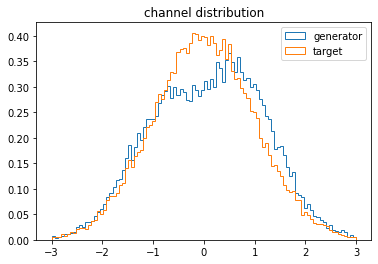

Time for epoch 1 is 6.2588067054748535 sec
G Loss is 0.659111738204956 and D loss is 1.3920137882232666
-----------------------------------------------------------------
Time for epoch 2 is 0.817354679107666 sec
G Loss is 0.6955204010009766 and D loss is 1.3848352432250977
-----------------------------------------------------------------


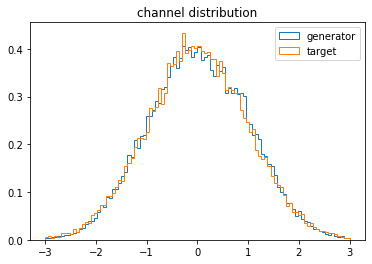

Time for epoch 3 is 3.561998128890991 sec
G Loss is 0.6896801590919495 and D loss is 1.386735439300537
-----------------------------------------------------------------
Time for epoch 4 is 0.7415425777435303 sec
G Loss is 0.694636344909668 and D loss is 1.3867366313934326
-----------------------------------------------------------------


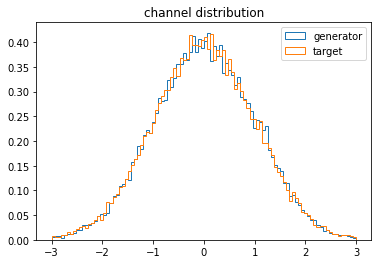

Time for epoch 5 is 3.5929956436157227 sec
G Loss is 0.6926207542419434 and D loss is 1.385581612586975
-----------------------------------------------------------------
Time for epoch 6 is 0.7339653968811035 sec
G Loss is 0.6911943554878235 and D loss is 1.3868317604064941
-----------------------------------------------------------------


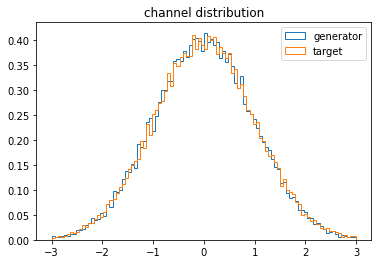

Time for epoch 7 is 3.582313060760498 sec
G Loss is 0.6929102540016174 and D loss is 1.3869423866271973
-----------------------------------------------------------------
Time for epoch 8 is 0.7369437217712402 sec
G Loss is 0.6910494565963745 and D loss is 1.3871557712554932
-----------------------------------------------------------------


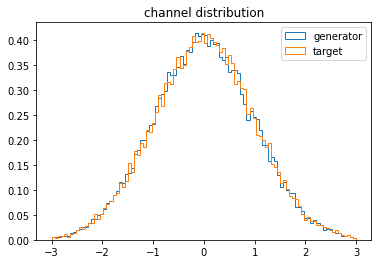

Time for epoch 9 is 3.6228830814361572 sec
G Loss is 0.6922830939292908 and D loss is 1.386846899986267
-----------------------------------------------------------------
Time for epoch 10 is 0.7348620891571045 sec
G Loss is 0.6880411505699158 and D loss is 1.3862617015838623
-----------------------------------------------------------------


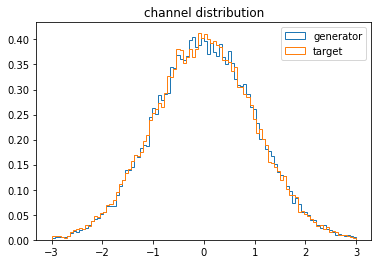

Time for epoch 11 is 3.460383653640747 sec
G Loss is 0.6944283246994019 and D loss is 1.3866019248962402
-----------------------------------------------------------------
Time for epoch 12 is 0.734715461730957 sec
G Loss is 0.6907040476799011 and D loss is 1.386576771736145
-----------------------------------------------------------------


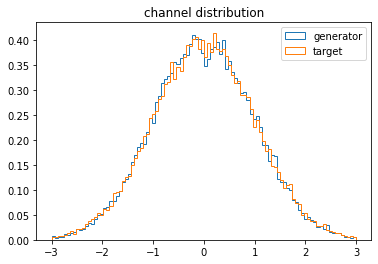

Time for epoch 13 is 3.4148285388946533 sec
G Loss is 0.6889561414718628 and D loss is 1.3871986865997314
-----------------------------------------------------------------
Time for epoch 14 is 0.7168943881988525 sec
G Loss is 0.6923912763595581 and D loss is 1.38688063621521
-----------------------------------------------------------------


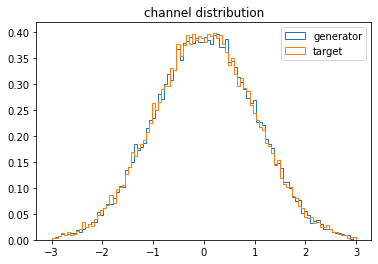

Time for epoch 15 is 3.5392940044403076 sec
G Loss is 0.6925246715545654 and D loss is 1.3864318132400513
-----------------------------------------------------------------
Time for epoch 16 is 0.7217435836791992 sec
G Loss is 0.6920756101608276 and D loss is 1.3863160610198975
-----------------------------------------------------------------


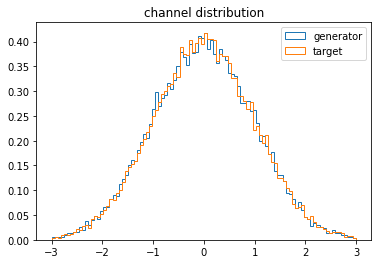

Time for epoch 17 is 3.534181594848633 sec
G Loss is 0.695151686668396 and D loss is 1.3863943815231323
-----------------------------------------------------------------
Time for epoch 18 is 0.7391421794891357 sec
G Loss is 0.6930484175682068 and D loss is 1.3866204023361206
-----------------------------------------------------------------


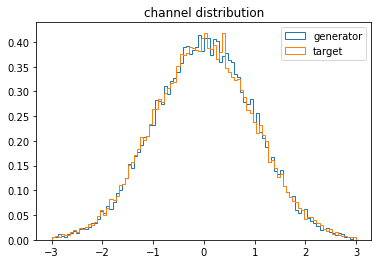

Time for epoch 19 is 3.6354410648345947 sec
G Loss is 0.693551242351532 and D loss is 1.3867740631103516
-----------------------------------------------------------------
Time for epoch 20 is 0.8035211563110352 sec
G Loss is 0.6975157260894775 and D loss is 1.386509656906128
-----------------------------------------------------------------


In [ ]:
train(EPOCHS)

In [ ]:
# It can be used to reconstruct the model identically.
# generator = keras.models.load_model("Desktop/my_generator", compile='False')
# test_step()
kl_div_metric = KL()
print('KL Div Metric: {}'.format(kl_div_metric ))

KL Div Metric: 0.002450334804828323


## Autoencoder over the AWGN channel (estimated with CGAN)
We can train over Rayleigh or Rician if more appropriate 

### Autoencoder parameters

In [ ]:
k = 4                               # bit per autoencoder message
M = 2**k                            # total nb of autoencoder messages
n = 2        

### The Encoder / Transmitter

In [ ]:
encoder_input = tf.keras.Input(shape=(), dtype=tf.int32, name='enc_in')
one_hot = tf.one_hot(encoder_input,depth=M)
x = tf.keras.layers.Dense(128,activation="relu")(one_hot)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dense(n,activation=None)(x)
encoder_output = x / tf.sqrt(tf.reduce_mean(tf.square(x)))    # batch normalization to limit average signal power to 1.0 (per complex channel use)
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf.one_hot (TFOpLambda)         (None, 16)           0           enc_in[0][0]                     
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          2176        tf.one_hot[0][0]                 
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          16512       dense_7[0][0]                    
____________________________________________________________________________________________

#### Test the transmitter 
Generate signals for a batch of all possible M messages and have a look at the encoded signals

In [ ]:
x = encoder(np.arange(M,dtype=np.int32)).numpy()
print(x)
print(x.shape)

[[ 1.7032449   0.6526038 ]
 [-1.1287526   1.1403582 ]
 [ 0.4509344   0.604247  ]
 [ 0.82613313  0.9862088 ]
 [ 0.86013955  0.5299808 ]
 [-1.6854037   0.73480016]
 [ 0.23647833  1.1517571 ]
 [ 0.81928855  0.6732449 ]
 [ 0.28703198  0.59125024]
 [-0.6640481  -0.458985  ]
 [ 0.23966509  1.3413879 ]
 [ 2.099693    1.637684  ]
 [ 0.19651043  1.2812063 ]
 [ 1.7113937   1.3508092 ]
 [ 0.3395851   0.22359708]
 [-0.24564452  0.52576125]]
(16, 2)


#### Complex-valued constellation diagrams

The constellation our AE uses. The constellation is optimized to reduce the performance metric (BER) during training.

In [ ]:
def plot_constellation(maxrange=None, show_labels=False):
    '''Generate a plot of the current constellation'''
    x = encoder(np.arange(M,dtype=np.int32)).numpy()
    x = np.reshape(x,[M,int(n/2),2])
    if (maxrange is None):
        maxrange = np.max(np.abs(x))
    for k in range(int(n/2)):
        image = plt.figure(figsize=(6,6))
        plt.grid(True)
        plt.xlim(-maxrange,maxrange)
        plt.ylim(-maxrange,maxrange)
        for i in range(M):       
            plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')
            if show_labels:
                plt.annotate(str(L[i].numpy()),(x[i,k,0],x[i,k,1]),c="gray",ha='center',xytext=(0, 5),textcoords='offset points')
        image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
        image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
        image.suptitle('%d. complex symbol' % (k+1))
        plt.xlabel('Re')
        plt.ylabel('Im')
    return x, image

This is what the AE constellation looks like before training. Based on communication theory, we know that maximizing the Euclidean distance in addition to using Gray code between any two neightbouring constellation points reduces the probability of making an error.

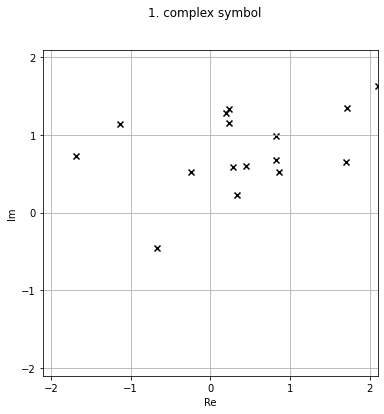

In [ ]:
plot_constellation();

#### Bit-Labeling for each AE message
Label each of the M messages with a sequence of k bit (groud-truth labels)

In [ ]:
def get_bit_label_natural(k):
    M=2**k
    label_natural = np.zeros((M,k))

    for j in range(M):
        for i in range(k):
            label_natural[j,i] = np.binary_repr(j, width = k)[i]
    return label_natural

L = tf.cast(get_bit_label_natural(k),dtype=tf.int8)
print(L.numpy())

[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]


#### Initial constellation with labels

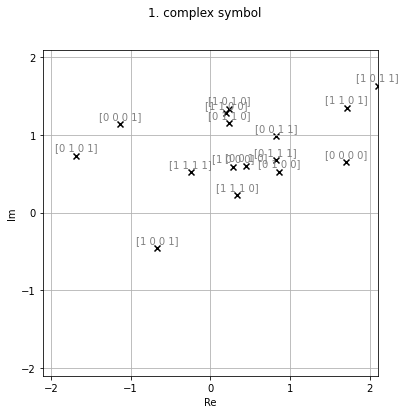

In [ ]:
plot_constellation(show_labels=True);

### Channel 
Use the trained CGAN as a surrogate for the real channel.

In [ ]:
# def ebnodb_2_noisestd(awgn_ebno_db):
#     return  1.0 / tf.sqrt(k/n * 2 * 10**(awgn_ebno_db/10.))  # noise variance per complex-valued component

# def awgn_channel(x,awgn_ebno_db):
#     noise_std = ebnodb_2_noisestd(awgn_ebno_db)
#     return x + tf.random.normal(shape=tf.shape(x)) * tf.cast(noise_std,dtype=tf.float32)

### The Decoder / Receiver

In [ ]:
decoder_input = tf.keras.Input(shape=(n), name='dec_in')
x = tf.keras.layers.Dense(128,activation="relu")(decoder_input)
x = tf.keras.layers.Dense(128,activation="relu")(x)
decoder_output = tf.keras.layers.Dense(k,activation=None)(x)
decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_in (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 516       
Total params: 17,412
Trainable params: 17,412
Non-trainable params: 0
_________________________________________________________________


### Training
**Things to implement/do**
*   Training vs Validation Loss/Accuracy Graph
*   Early Stopping
*   Training with low EbNo vs high EbNo
*   Training with long sequences 


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
def autoencode(batch_size,awgn_ebno_db):
    s = tf.random.uniform(shape=(batch_size,),minval=0,maxval=M,dtype=tf.int32)
    u = tf.gather(L,s)
    
    x = encoder(s)
    y = generator(x)
    u_l = decoder(y)
    
    return u,u_l

@tf.function
def train_step(batch_size,awgn_ebno_db):
    
    with tf.GradientTape() as tape:
        u,u_l = autoencode(batch_size,awgn_ebno_db)
        # Loss
        loss = tf.losses.binary_crossentropy(y_true=u,y_pred=-u_l,from_logits=True)

    trainable_weights = [] + encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_weights)
    # Applying gradients for this batch
    optimizer.apply_gradients(zip(gradients, trainable_weights))
    
    return tf.reduce_mean(loss)

@tf.function
def test_step(batch_size,awgn_ebno_db):
    u,u_l = autoencode(batch_size,awgn_ebno_db)
    
    # AE Performance metrics
    u_hat_hard = tf.cast(tf.less(u_l,0.0),tf.int8)
    correct_predictions = tf.equal(u_hat_hard,u)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    ber_hard = 1.0 - accuracy
    
    return ber_hard




test_step_2 and autoencode test are need to test the autoencoder trained on the CGAN model agains the real channel

In [ ]:
def ebnodb_2_noisestd(awgn_ebno_db):
    return  1.0 / tf.sqrt(k/n * 2 * 10**(awgn_ebno_db/10.))  # noise variance per complex-valued component

def awgn_channel(x,awgn_ebno_db):
    noise_std = ebnodb_2_noisestd(awgn_ebno_db)
    return x + tf.random.normal(shape=tf.shape(x)) * tf.cast(noise_std,dtype=tf.float32)

In [ ]:
    #to test with real channel
    def autoencode_test(batch_size,awgn_ebno_db):
        s = tf.random.uniform(shape=(batch_size,),minval=0,maxval=M,dtype=tf.int32)
        u = tf.gather(L,s)
    
        x = encoder(s)
        y = awgn_channel(x,awgn_ebno_db)
        u_l = decoder(y)
    
        return u,u_l

     #used with autoencode_test
    def test_step_2(batch_size,awgn_ebno_db):
        u,u_l = autoencode_test(batch_size,awgn_ebno_db)
    
      # AE Performance metrics
        u_hat_hard = tf.cast(tf.less(u_l,0.0),tf.int8)
        correct_predictions = tf.equal(u_hat_hard,u)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        ber_hard = 1.0 - accuracy
    
        return ber_hard 

In [ ]:
def validation_GAN_loss(batch_size,awgn_ebno_db):
    u,u_l = autoencode(batch_size,awgn_ebno_db)
    loss = tf.losses.binary_crossentropy(y_true=u,y_pred=-u_l,from_logits=True)
    return tf.reduce_mean(loss)

def plot_training_validation_loss(loss):
    '''Plot the training loss vs validation'''
    image = plt.figure(figsize=(10,8))
    #this wont give an error if you change the training params but it wont be right anymore
    #need to change the epoch upper limit if training params are changed
    epoch = np.linspace(0,3.9,np.size(loss,0))
    plt.plot(epoch, loss[:,0], '-r', linewidth=2.0)
    #plt.plot(epoch, loss[:,1], '-g', linewidth=2.0)
    plt.plot(epoch, loss[:,1], '-b', linewidth=2.0)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.grid(True)
    plt.yscale('log')
    image.axes[0].set_xticks(np.array([0,1,2,3,4]))
    #plt.ylim([1e-5,1])
    #plt.legend(['Training',  'Validation Generator','Validation Real Channel']);
    plt.legend(['Training','Validation']);#,'Validation Real Channel']);
    return 

In [ ]:
def train(training_params, validation_params):  
    '''Training and validation loop'''
    losses = np.empty([50,2])
    for index, params in enumerate(training_params):
        batch_size, lr, ebnodb, iterations = params
        print('\nBatch Size: ' + str(batch_size) +
              ', Learning Rate: ' + str(lr) +
              ', EbNodB: ' + str(ebnodb) +
              ', Iterations: ' + str(iterations))

        val_size, val_ebnodb, val_steps = validation_params[index]

        for i in range(iterations):
            optimizer.learning_rate = lr
            loss = train_step(tf.constant(batch_size), tf.constant(ebnodb)).numpy()
            if (i%val_steps==0):
                ber = test_step(val_size,val_ebnodb).numpy()
                val_loss = validation_GAN_loss(val_size,val_ebnodb).numpy()
                losses[index*10+i//val_steps] = loss, val_loss
                print("loss: %.3e    BER: %.3e" % (loss,ber))
    return losses

def ber_sim(ebnodbs, batch_size, iterations):
    '''Monte Carlo simulations of BER for a range of Eb/No
       Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
       You can average over multiple batches with small size instead.           
    '''
    BER = np.zeros_like(ebnodbs)
    for i in range(iterations):
        #ber = np.array([test_step(tf.constant(batch_size), tf.constant(ebnodb)).numpy() for ebnodb in ebnodbs])
        ber = np.array([test_step_2(tf.constant(batch_size), tf.constant(ebnodb)).numpy() for ebnodb in ebnodbs])

        BER = BER + ber/iterations
    return BER

def plot_ber(EbNodB, BER):
    '''Plot a BER vs SNR curve'''
    image = plt.figure(figsize=(10,8))
    plt.plot(EbNodB, BER, '-r', linewidth=2.0)
    plt.yscale('log')
    plt.xlabel('EbNo (dB)', fontsize=18)
    plt.ylabel('Bit-error rate', fontsize=18)
    plt.grid(True)
    plt.ylim([1e-5,1])
    return image

#### Training parameters

Here we define the SNR during training. The autoencoder will then be trained to find an optimal constellation for this specific training SNR.
Mind that this constellation might not be the optimal constellation for the total SNR range, also the receiver is only trained to demap at training SNR.

In [ ]:
train_EbNodB = 15.0
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [1000    , 0.0001, train_EbNodB, 1000],
    [10000    , 0.0001, train_EbNodB, 1000],
    [100000    , 0.0001, train_EbNodB, 1000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100, val_EbNodB, 100],
    [1000 , val_EbNodB, 100],
    [10000 , val_EbNodB, 100],
    [100000, val_EbNodB, 100]
]


#### Train

In [ ]:
losses = train(training_params,validation_params)


Batch Size: 100, Learning Rate: 0.001, EbNodB: 15.0, Iterations: 1000
loss: 7.009e-01    BER: 4.975e-01
loss: 1.925e-01    BER: 3.750e-02
loss: 2.643e-02    BER: 0.000e+00
loss: 8.685e-03    BER: 0.000e+00
loss: 3.312e-03    BER: 0.000e+00
loss: 2.180e-03    BER: 0.000e+00
loss: 1.291e-03    BER: 0.000e+00
loss: 1.138e-03    BER: 0.000e+00
loss: 8.989e-04    BER: 0.000e+00
loss: 6.138e-04    BER: 0.000e+00

Batch Size: 1000, Learning Rate: 0.0001, EbNodB: 15.0, Iterations: 1000
loss: 4.580e-04    BER: 0.000e+00
loss: 3.483e-04    BER: 0.000e+00
loss: 2.783e-04    BER: 0.000e+00
loss: 2.726e-04    BER: 0.000e+00
loss: 2.669e-04    BER: 0.000e+00
loss: 2.236e-04    BER: 0.000e+00
loss: 1.549e-04    BER: 0.000e+00
loss: 1.603e-04    BER: 0.000e+00
loss: 1.404e-04    BER: 0.000e+00
loss: 1.289e-04    BER: 0.000e+00

Batch Size: 10000, Learning Rate: 0.0001, EbNodB: 15.0, Iterations: 1000
loss: 1.025e-04    BER: 0.000e+00
loss: 4.907e-05    BER: 0.000e+00
loss: 2.918e-05    BER: 0.000e+00


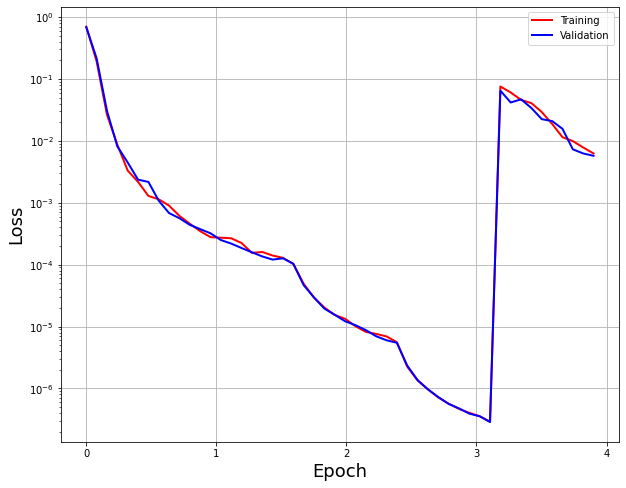

In [ ]:
plot_training_validation_loss(losses)

### Evaluation

The found constellation afte training

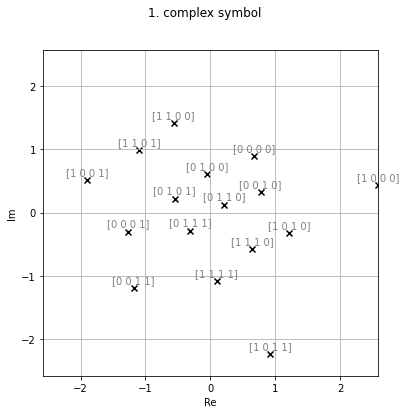

In [ ]:
plot_constellation(show_labels=True);

#### BER perfomance evaluation
AE's BER performance vs classical baselines.
The baseline results are taken from our webdemo [Physical Layer Performance Measures - Symbol Error Rate, BER and Mutual Information](https://webdemo.inue.uni-stuttgart.de/webdemos/02_lectures/communication_3/performance_measures/).

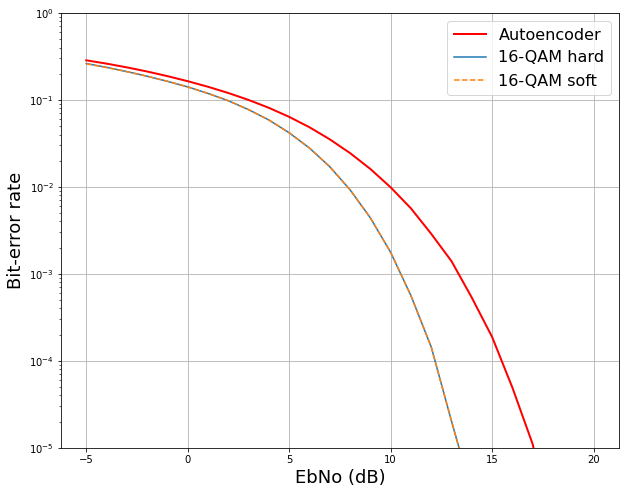

In [ ]:
# reference curves
ebnodbs_ref = np.linspace(-5,20,26)
ber_ref_hard_n2 = np.array([[2.132e-01, 1.861e-01, 1.588e-01, 1.303e-01, 1.037e-01, 7.823e-02, 5.592e-02, 3.737e-02, 2.282e-02, 1.249e-02, 5.959e-03, 2.385e-03, 7.400e-04, 2.050e-04, 3.500e-05, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.137e-01, 1.857e-01, 1.581e-01, 1.310e-01, 1.042e-01, 7.860e-02, 5.629e-02, 3.746e-02, 2.302e-02, 1.241e-02, 5.978e-03, 2.387e-03, 7.570e-04, 2.010e-04, 3.600e-05, 5.000e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.713e-01, 2.474e-01, 2.231e-01, 1.966e-01, 1.697e-01, 1.426e-01, 1.152e-01, 8.909e-02, 6.482e-02, 4.411e-02, 2.738e-02, 1.539e-02, 7.492e-03, 3.011e-03, 1.000e-03, 2.537e-04, 4.100e-05, 2.667e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.618e-01, 2.367e-01, 2.116e-01, 1.872e-01, 1.636e-01, 1.411e-01, 1.187e-01, 9.781e-02, 7.725e-02, 5.876e-02, 4.186e-02, 2.795e-02, 1.704e-02, 9.262e-03, 4.407e-03, 1.768e-03, 5.617e-04, 1.443e-04, 2.025e-05, 3.000e-06, 5.000e-07, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
ber_ref_soft_n2 = np.array([[2.132e-01, 1.861e-01, 1.588e-01, 1.303e-01, 1.037e-01, 7.823e-02, 5.592e-02, 3.737e-02, 2.282e-02, 1.249e-02, 5.959e-03, 2.385e-03, 7.400e-04, 2.050e-04, 3.500e-05, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.137e-01, 1.858e-01, 1.582e-01, 1.309e-01, 1.043e-01, 7.858e-02, 5.627e-02, 3.746e-02, 2.301e-02, 1.241e-02, 5.978e-03, 2.387e-03, 7.570e-04, 2.010e-04, 3.600e-05, 5.000e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.655e-01, 2.423e-01, 2.188e-01, 1.932e-01, 1.674e-01, 1.410e-01, 1.143e-01, 8.866e-02, 6.462e-02, 4.401e-02, 2.734e-02, 1.537e-02, 7.492e-03, 3.011e-03, 9.997e-04, 2.537e-04, 4.100e-05, 2.667e-06, 1.000e-06, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],[2.600e-01, 2.356e-01, 2.110e-01, 1.869e-01, 1.635e-01, 1.410e-01, 1.187e-01, 9.781e-02, 7.725e-02, 5.876e-02, 4.186e-02, 2.795e-02, 1.704e-02, 9.262e-03, 4.407e-03, 1.768e-03, 5.617e-04, 1.443e-04, 2.025e-05, 3.000e-06, 5.000e-07, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
#ber_ref_theory_n2 = np.array([[2.132e-01, 1.861e-01, 1.584e-01, 1.306e-01, 1.038e-01, 7.865e-02, 5.628e-02, 3.751e-02, 2.288e-02, 1.250e-02, 5.954e-03, 2.388e-03, 7.727e-04, 1.909e-04, 3.363e-05, 3.872e-06, 2.613e-07, 9.006e-09, 1.333e-10, 6.810e-13, 9.124e-16, 2.267e-19, 6.759e-24, 1.396e-29, 1.001e-36, 1.044e-45],[2.132e-01, 1.861e-01, 1.584e-01, 1.306e-01, 1.038e-01, 7.865e-02, 5.628e-02, 3.751e-02, 2.288e-02, 1.250e-02, 5.954e-03, 2.388e-03, 7.727e-04, 1.909e-04, 3.363e-05, 3.872e-06, 2.613e-07, 9.006e-09, 1.333e-10, 6.810e-13, 9.124e-16, 2.267e-19, 6.759e-24, 1.396e-29, 1.001e-36, 1.044e-45],[3.491e-01, 3.162e-01, 2.814e-01, 2.452e-01, 2.081e-01, 1.712e-01, 1.355e-01, 1.023e-01, 7.282e-02, 4.821e-02, 2.917e-02, 1.578e-02, 7.423e-03, 2.931e-03, 9.298e-04, 2.241e-04, 3.827e-05, 4.239e-06, 2.724e-07, 8.827e-09, 1.209e-10, 5.603e-13, 6.640e-16, 1.414e-19, 3.470e-24, 5.611e-30],[3.075e-01, 2.863e-01, 2.633e-01, 2.387e-01, 2.127e-01, 1.855e-01, 1.578e-01, 1.301e-01, 1.032e-01, 7.816e-02, 5.586e-02, 3.716e-02, 2.262e-02, 1.233e-02, 5.854e-03, 2.339e-03, 7.529e-04, 1.849e-04, 3.231e-05, 3.684e-06, 2.456e-07, 8.334e-09, 1.210e-10, 6.030e-13, 7.832e-16, 1.872e-19]])

# autoencoder simulations
ebnodbs = np.linspace(-5,20,26)
bers = ber_sim(ebnodbs, 100000, 10);
plot_ber(ebnodbs, bers);

plt.plot(ebnodbs_ref,ber_ref_hard_n2[k-1]);
plt.plot(ebnodbs_ref,ber_ref_soft_n2[k-1],"--");
#plt.plot(ebnodbs_ref,ber_ref_theory_n2[k-1],"--");

plt.legend(['Autoencoder', '%d-QAM hard' % M,'%d-QAM soft' % M, 'closed-form approx.'], prop={'size': 16}, loc='upper right');

### Things to improve upon
Training vs Validation Loss Graph
It is a standard practice to show training vs validation loss/accuracy graph to illustrate whether the learning-based model generalizes well or if it overfits/underfit. We will implement this and put it in our report

Illustrate that when trained with low EbNos, the model has diffculty learning the optimal constellation that generalizes well across a wide range of EbNos. We can interpret this as using inaccurate ground-truth labels in a supervised learning task, and the model is unable to learn the general relationship between the input and output.